In [1]:
import pandas as pd
import numpy as np

In [2]:
copy_number = pd.read_csv('OmicsCNGene.csv', index_col=0)
gene_effect = pd.read_csv('CRISPRGeneEffect.csv', index_col=0)

In [7]:
print('Copy Number File....\n')
print(f'Gene Count : {copy_number.shape[1]}')
print(f'Cell Line Count : {copy_number.shape[0]}')

Copy Number File....

Gene Count : 24383
Cell Line Count : 1788


In [6]:
# Check for Nan value
print(f'Nan Value : {copy_number.isna().value_counts().sum()}')

Nan Value : 1788


In [8]:
print('CRISPR Gene Effect File....\n')
print(f'Gene Count : {gene_effect.shape[1]}')
print(f'Cell Line Count : {gene_effect.shape[0]}')

CRISPR Gene Effect File....

Gene Count : 18443
Cell Line Count : 1150


In [9]:
# Check for Nan value
print(f'Nan Value : {gene_effect.isna().value_counts().sum()}')

Nan Value : 1150


# Filter Out X, Y Related Gene
## Data Source:  https://www.gsea-msigdb.org/gsea/msigdb/index.jsp (C1- X, Y)

In [20]:
# List of X, Y Gene
import json
import os 

def load_file(directory):
    '''
    Get File name

    Return:
    json file list
    '''
    json_file = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')]

    return json_file

def get_gene_list(file_names):
    '''
    Get Target Gene List

    Return:
    Gene List
    '''
    gene_list = []
    for idx, name in enumerate(file_names):
        with open(name, 'r') as file:
            data = json.load(file)
            top_key = list(data.keys())[0]
            print(f'Process Number:{idx+1}')
            print(f'Processing File:{top_key}\n')
            gene_symbols = data[top_key]['geneSymbols']
            print(f'Gene Symbol Count:{len(gene_symbols)}')
            print(f'---------------------------------------\n')

            if isinstance(gene_symbols, list):
                gene_list.extend(gene_symbols)
            else:
                gene_list.append(gene_symbols)

    return gene_list


In [21]:
# Load X chrom gene symbol
directory = 'X_Chrom'
file_names = load_file(directory)

x_gene_list = get_gene_list(file_names)

# Load Y Chrom gene symbol
directory = 'Y_Chrom'
file_names = load_file(directory)

y_gene_list = get_gene_list(file_names)

Process Number:1
Processing File:chrXp11

Gene Symbol Count:377
---------------------------------------

Process Number:2
Processing File:chrXp21

Gene Symbol Count:84
---------------------------------------

Process Number:3
Processing File:chrXp22

Gene Symbol Count:250
---------------------------------------

Process Number:4
Processing File:chrXq11

Gene Symbol Count:30
---------------------------------------

Process Number:5
Processing File:chrXq12

Gene Symbol Count:26
---------------------------------------

Process Number:6
Processing File:chrXq13

Gene Symbol Count:165
---------------------------------------

Process Number:7
Processing File:chrXq21

Gene Symbol Count:143
---------------------------------------

Process Number:8
Processing File:chrXq22

Gene Symbol Count:172
---------------------------------------

Process Number:9
Processing File:chrXq23

Gene Symbol Count:89
---------------------------------------

Process Number:10
Processing File:chrXq24

Gene Symbol Coun

In [22]:
# Check Count of X, Y Gene Symbol
print('X Chrom Gene Symbol Count:')
print(len(x_gene_list))
print('\nY Chrom Gene Symbol Count:')
print(len(y_gene_list))

X Chrom Gene Symbol Count:
1940

Y Chrom Gene Symbol Count:
473


In [23]:
# Append two gene symbol
target_gene_list = x_gene_list + y_gene_list

In [24]:
def filt_col(data, gene_list):
    '''
    Data Filteration without target list

    Return:
    Filtered DataFrame
    '''
    columns_without_parentheses = [col.split(' (')[0] for col in data.columns]

    filtered_columns = [
        col for col, col_without_paren in zip(data.columns, columns_without_parentheses) 
        if col_without_paren not in gene_list
    ]

    filt_df = data[filtered_columns]

    return filt_df

In [25]:
filt_copy_number = filt_col(copy_number, target_gene_list)
filt_gene_effect = filt_col(gene_effect, target_gene_list)

In [26]:
print(f'After Filteration...\n')
print(f'Copy Number : {copy_number.shape[1]} ---->  {filt_copy_number.shape[1]}')
print(f'Gene Effect : {gene_effect.shape[1]} ---->  {filt_gene_effect.shape[1]}')

After Filteration...

Copy Number : 24383 ---->  23440
Gene Effect : 18443 ---->  17707


In [27]:
common_index = filt_copy_number.index.intersection(filt_gene_effect.index)

print(f'Intersected Cell Line(Count): {len(common_index)}')
copy_number = filt_copy_number.loc[common_index]
gene_effect = filt_gene_effect.loc[common_index]

Intersected Cell Line(Count): 1150


In [28]:
column_counts = []


for column in filt_copy_number.columns:
    #q1 = copy_number[column].quantile(0.25)
    count = ((filt_copy_number[column] >= 0) & (filt_copy_number[column] <= 0.5)).sum() 
    column_counts.append({'Gene': column, 'Count': count})


column_count_df = pd.DataFrame(column_counts)
column_count_df

,Gene,Count
0,FAM87B (400728),32
1,LINC01128 (643837),32
2,AL669831.7 (107984850),32
3,FAM41C (284593),33
4,LINC02593 (100130417),31
...,...,...
23435,BX546450.1 (105377213),416
23436,AC236972.3 (105373373),405
23437,AF274858.1 (105373383),407
23438,TAZ (6901),402


In [29]:
# Sorted by Count 
column_count_df.sort_values(by= 'Count', ascending=False, inplace=True)

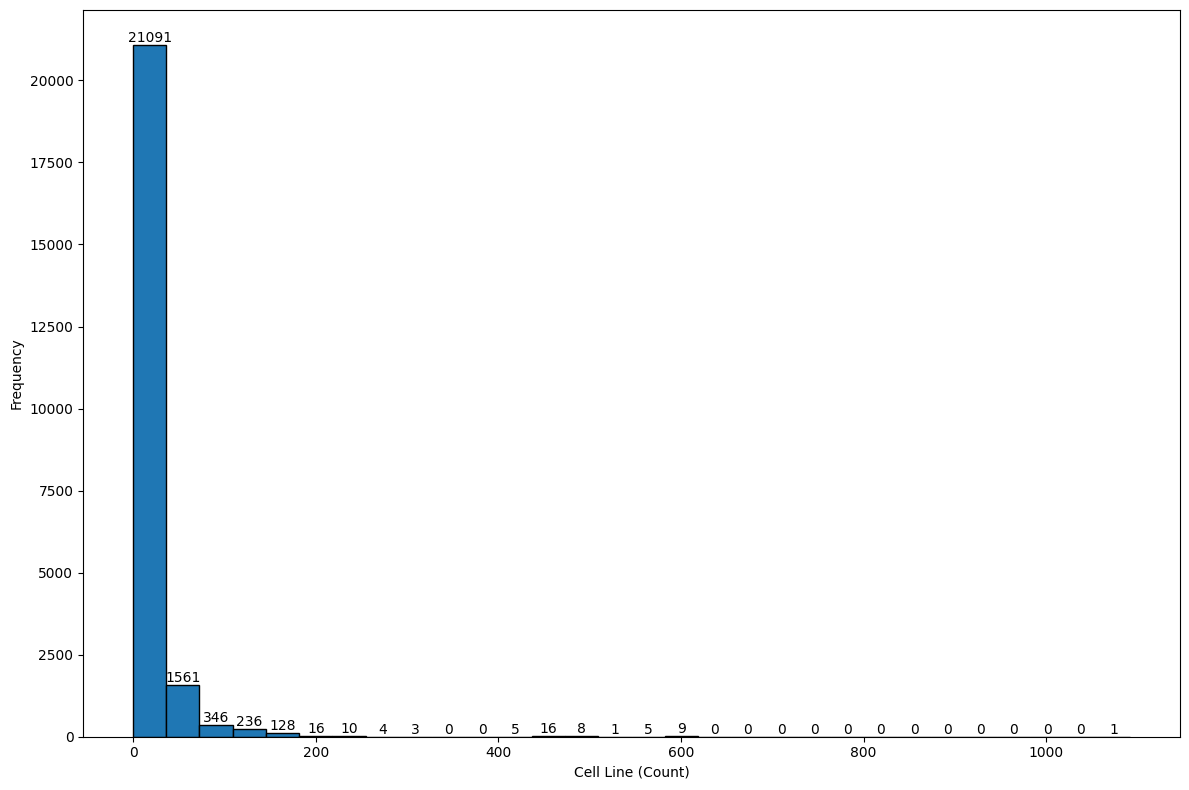

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

counts, bins, patches = plt.hist(column_count_df['Count'], bins=30, edgecolor='black')


for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    x = (bin_left + bin_right) / 2  
    y = count  
    plt.text(x, y, f'{int(count)}', ha='center', va='bottom')  


plt.xlabel('Cell Line (Count)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


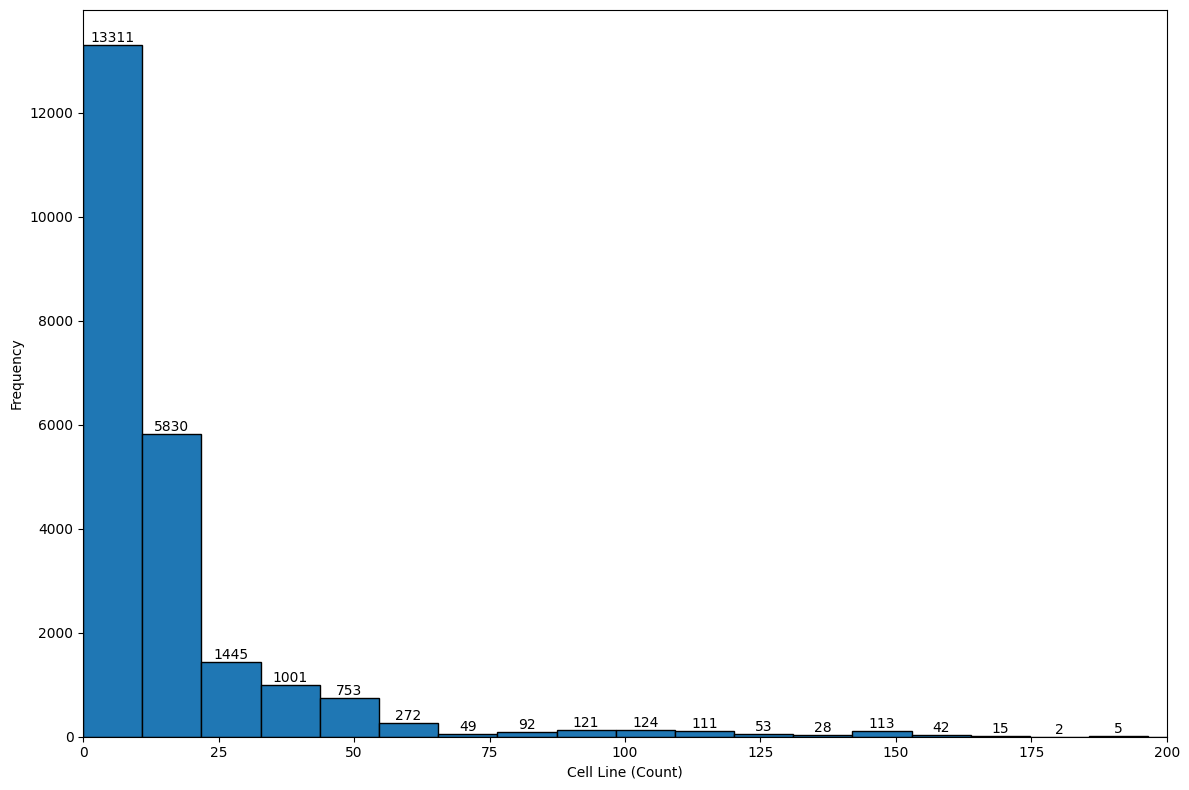

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Histogram Visualization
counts, bins, patches = plt.hist(column_count_df['Count'], bins=100, edgecolor='black')

# Text Add
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    x = (bin_left + bin_right) / 2  
    y = count  
    if 0 <= x <= 200:  # Setting Ranage
        plt.text(x, y, f'{int(count)}', ha='center', va='bottom')  

# X setting
plt.xlim(0, 200)

# Labeling
plt.xlabel('Cell Line (Count)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [35]:
# Filtered Cell Line Count
filt_column_count_df = column_count_df[column_count_df['Count'] >= 100]

In [36]:
# Choose top 50 gene
filtered_genes = column_count_df['Gene'].head(50)
filtered_genes

23439    AC010889.2 (105377224)
22576             CDKN2A (1029)
23407    AC091806.1 (101927476)
23406    AF241728.2 (105373174)
23405    AL606516.1 (101928627)
23401    AC074035.1 (101928201)
23408    AF196972.1 (101927635)
23409       USP27X-AS1 (158572)
23410    AC231759.2 (105377209)
23404           CXorf21 (80231)
23402      Z93022.1 (101928389)
23403    AL732509.1 (101928415)
22578             CDKN2B (1030)
23411           FAM104B (90736)
23412     MTRNR2L10 (100463488)
22577    CDKN2B-AS1 (100048912)
23414    AL139398.1 (105373244)
7518       MIR1268A (100302233)
23413           FAM155B (27112)
23415    BX276092.9 (101059915)
23423     LINC01402 (104797536)
23424    AL513487.1 (101928359)
23421    AC004835.1 (101928336)
23422           CXorf56 (63932)
7517           CHEK2P2 (646096)
23416      Z70719.1 (105373299)
23419         AL035425.2 (8471)
23417            BHLHB9 (80823)
23426    AL445072.1 (101928495)
23420            TDGF1P3 (6998)
23425    AL121601.1 (101928402)
23418   

In [90]:
# Remove na value by intersected index
filtered_copy_number = filt_copy_number[filtered_genes]
#filtered_copy_number = filtered_copy_number.dropna()

#common_index = gene_effect.index.intersection(filtered_copy_number.index)


#filt_gene_effect = gene_effect.loc[common_index]


In [96]:
from scipy.stats import pearsonr

# Initialize dictionary to store results with correlation > 0.3 and p-value < 0.05
filtered_correlation_results = {}

for copy_col in filtered_copy_number.columns:
    filtered_correlation_results[copy_col] = {}
    
    for effect_col in gene_effect.columns:
        valid_data = pd.concat([gene_effect[effect_col], filtered_copy_number[copy_col]], axis=1)
        valid_data = valid_data.dropna()  # Remove NaN values
        
        if len(valid_data) > 1:
            # Calculate correlation and p-value
            cell_line_count = len(valid_data)
            corr_val, p_val = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            
            # Filter based on conditions
            if corr_val >= 0.3 and p_val < 0.05:
                filtered_correlation_results[copy_col][effect_col] = {'correlation': corr_val, 'p_value': p_val, 'cell_line': cell_line_count}

# Convert to DataFrame for better visualization
filtered_correlation_df = pd.DataFrame(filtered_correlation_results)

In [98]:
# Target Gene filtering
target_gene = ['BCORP1 (286554)', 'KDM5D (8284)', 'CDKN2A (1029)', 'KDM6A (7403)', 'ASMTL (8623)', 'CSF2RA (1438)', 'SLC25A6 (293)', 'IL3RA (3563)', 'ASMT (438)'
                ,'P2RY8 (286530)', 'AKAP17A (8227)', 'LINC00106 (751580)', 'CRLF2 (64109)', 'PLCXD1 (55344)', 'GTPBP6 (8225)', 'PPP2R3B (28227)', 'CYBB (1536)',
                'DYNLT3 (6990)', 'CASK (8573)']

target_correlation_df = filtered_correlation_df[target_gene]
target_correlation_df.to_excel('target_correlation_df.xlsx')